<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/non_linear_ica_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on Nonlinear ICA Using Auxiliary Variables
and Generalized Contrastive Learning: https://arxiv.org/pdf/1805.08651.pdf

# Import stock prices

In [126]:
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import regularizers
import time
from __future__ import division

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline
plt.style.use('ggplot')

yf.pdr_override()

stocks = ["VTI", "VXUS"]
start = dt.datetime(2016,5,1)
end = dt.datetime(2019,5,1)

f = pdr.get_data_yahoo(stocks, start=start, end=end)

[*********************100%***********************]  2 of 2 downloaded


In [127]:
f.tail()

Open                   High  ...  Adj Close   Volume         
                   VTI       VXUS         VTI  ...       VXUS      VTI     VXUS
Date                                           ...                             
2019-04-24  149.779999  53.200001  150.050003  ...  52.422779  1924600  1056700
2019-04-25  149.539993  52.860001  149.690002  ...  52.333809  2428600   942000
2019-04-26  149.410004  53.090000  150.160004  ...  52.610603  2184500   710400
2019-04-29  150.220001  53.230000  150.690002  ...  52.739113  2461500  1228500
2019-04-30  150.279999  53.279999  150.600006  ...  52.729229  2224500  1284500

[5 rows x 12 columns]

In [0]:
close = f['Adj Close'].values

In [0]:
close = close/close[0,:]

In [0]:
N = close.shape[0]

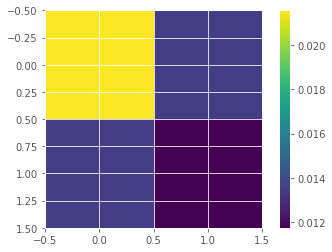

In [130]:
plt.imshow(np.cov(close.T));
plt.colorbar();

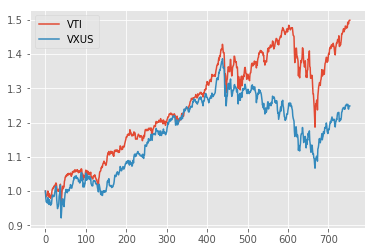

In [131]:
for i in range(close.shape[1]):
  plt.plot(np.array(range(close.shape[0])), close[:,i]);
plt.legend(['VTI', 'VXUS']);

In [0]:
x = close #input
d = np.array(range(x.shape[0])) #time label
d = (d-np.mean(d))/np.std(d)

d_random = d[np.random.permutation(d.shape[0])] #random time

c_true = 1+np.zeros([x.shape[0],1], np.int32) #true means 1
c_false = np.zeros([x.shape[0],1], np.int32) #false means 0


features = np.concatenate((x,x), axis=0).astype(np.float32) 
auxilary = np.concatenate((d,d_random), axis=0).astype(np.float32).reshape([-1,1])
labels = np.concatenate((c_true, c_false), axis=0).astype(np.float32)

In [0]:
tf.reset_default_graph()

shuff = tf.placeholder(tf.int64, name='shuff')

batch_size = tf.placeholder(tf.int64, name='batch') 
train_data = (features, auxilary, labels) #inputs and targets - they are the same for the autoencoder
train_data = tf.data.Dataset.from_tensor_slices(train_data)
train_data = train_data.shuffle(buffer_size=shuff)
train_data = train_data.batch(batch_size)

#Create an iterator
iterator = tf.data.Iterator.from_structure(train_data.output_types, train_data.output_shapes)
X, U, Y = iterator.get_next()
train_init = iterator.make_initializer(train_data)

def encoder(x, activation, regularizer, name):
  with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
    h = tf.layers.dense(x, 16, activation, kernel_regularizer=regularizer)
    h = tf.layers.dense(h, 8, activation, kernel_regularizer=regularizer)
    h = tf.layers.dense(h, 4, activation, kernel_regularizer=regularizer)
    z = tf.layers.dense(h, 2)
  return z


def latent_aux(z, u, activation, regularizer, name):
  with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
    k = tf.concat([z, u], axis=1) #latent representation plus auxilary data
    k = tf.layers.dense(k,16, activation, kernel_regularizer=regularizer)
    k = tf.layers.dense(k,8, activation, kernel_regularizer=regularizer)
    k = tf.layers.dense(k,4, activation, kernel_regularizer=regularizer)
    k = tf.layers.dense(k,1)
  return k

z = encoder(X, tf.nn.leaky_relu, tf.contrib.layers.l2_regularizer(scale=0.00001),  'encoder')

z_1 = tf.reshape(z[:,0],[-1,1])
z_2 = tf.reshape(z[:,1],[-1,1])

k_1 = latent_aux(z_1, U, tf.nn.leaky_relu, tf.contrib.layers.l2_regularizer(scale=0.00001), 'k_1')
k_2 = latent_aux(z_2, U, tf.nn.leaky_relu, tf.contrib.layers.l2_regularizer(scale=0.00001), 'k_2')
  
k = k_1+k_2

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=k)
loss = tf.reduce_mean(cross_entropy) + tf.losses.get_regularization_loss()
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

predicted = tf.nn.sigmoid(k)
correct_pred = tf.equal(tf.round(predicted), Y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [134]:
#Create a training session
import time
saver = tf.train.Saver()
with tf.Session() as sess:
    start_time = time.time()
    sess.run(tf.global_variables_initializer())
    for i in range(500):
        sess.run(train_init, feed_dict={batch_size: 16, shuff: 10000})
        total_loss = 0 #total loss
        total_acc = 0
        n_batches = 0
        try:
            while True:
                _, _loss, acc  = sess.run([optimizer, loss, accuracy])
                total_loss += _loss
                total_acc += acc
                n_batches += 1
        except tf.errors.OutOfRangeError:
            pass
        if i % 50 == 0:
          print('Epoch: {0}, loss: {1:.4f}, acc: {2:.4f}'
                .format(i, total_loss/n_batches, total_acc/n_batches))
    print('Total time: {0} seconds'.format(time.time() - start_time))
    
    
    #Calculate the decoder mean for the training data X
    sess.run(train_init, feed_dict={batch_size: features.shape[0], shuff: 1})
    try:
      while True:
        #latent, classes_out, labels_, grad1_out, grad2_out= sess.run([z, U, Y, grad1, grad2])
        latent_, X_ = sess.run([z, X])
    except tf.errors.OutOfRangeError:
      pass

Epoch: 0, loss: 0.6964, acc: 0.5033
Epoch: 50, loss: 0.3345, acc: 0.8612
Epoch: 100, loss: 0.3276, acc: 0.8605
Epoch: 150, loss: 0.3226, acc: 0.8658
Epoch: 200, loss: 0.3045, acc: 0.8763
Epoch: 250, loss: 0.2922, acc: 0.8822
Epoch: 300, loss: 0.2985, acc: 0.8743
Epoch: 350, loss: 0.2706, acc: 0.8901
Epoch: 400, loss: 0.2764, acc: 0.8921
Epoch: 450, loss: 0.2597, acc: 0.8993
Total time: 120.63364720344543 seconds


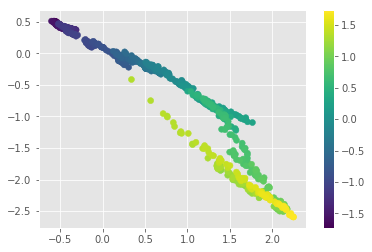

In [136]:
plt.scatter(latent_[0:N,0], latent_[0:N,1], c=d)
plt.colorbar()

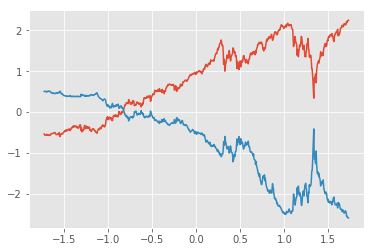

In [137]:
plt.plot(d, latent_[0:N,0])
plt.plot(d, latent_[0:N,1])

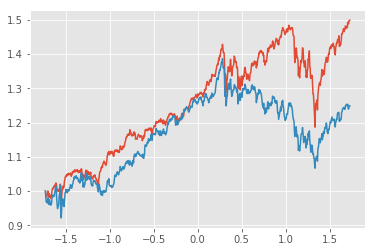

In [138]:
plt.plot(d, close[:,0])
plt.plot(d, close[:,1])